In [1]:
import matplotlib.pyplot as plt
import config
import pandas as pd
import numpy as np
import download_files
import seaborn as sns

/home/julius/GitHub/pdf-downloader-multithreading/.venv/lib/python3.13/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
df_excel = pd.read_excel(
        download_files.data_config.data_file,
        sheet_name=download_files.data_config.sheet_name,
        index_col=download_files.data_config.id_column,
    )

In [3]:
def unroll_json(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame.from_dict(df["download_status"].to_dict())
    df_stacked = df.stack().reset_index()
    df_stacked.columns = ["id", "run", "values"]
    df_expanded = pd.DataFrame(df_stacked["values"].tolist(), columns=["success", "status_code", "url"])
    df_final = pd.concat([df_stacked[["id", "run"]], df_expanded], axis=1)
    return df_final

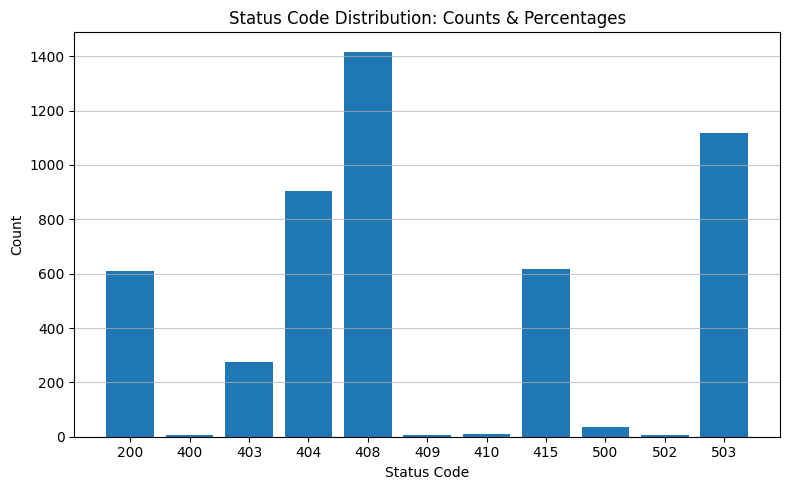

In [4]:
df_vectorized = pd.read_json("benchmarks/benchmarks_pandas_vectorization.json", orient="index")
df = unroll_json(df_vectorized)

df.columns = ["id", "run", "success", "status code", "url"]
counts = df["status code"].value_counts().sort_index()
percentages = counts / counts.sum() * 100
total = counts.sum()


fig, ax1 = plt.subplots(figsize=(8, 5))

bars = ax1.bar(counts.index.astype(str), counts, label='Counts')

ax1.set_xlabel("Status Code")
ax1.set_ylabel("Count")
ax1.set_title("Status Code Distribution: Counts & Percentages")
ax1.grid(axis='y', alpha=0.7)

plt.tight_layout()
plt.show()


In [5]:
df_sequential = pd.read_json("benchmarks/benchmarks_sequential.json", orient="index")
df_sequential_status = unroll_json(df_sequential)

df_iterrows = pd.read_json("benchmarks/benchmarks_iterrows.json", orient="index")
df_iterrows_status = unroll_json(df_iterrows)

df_vectorization = pd.read_json("benchmarks/benchmarks_pandas_vectorization.json", orient="index")
df_vectorization_status = unroll_json(df_vectorization)

means = [
    np.mean(df_sequential["elapsed_time"]),
    np.mean(df_iterrows["elapsed_time"]),
    np.mean(df_vectorization["elapsed_time"])
]

std_devs = [
    np.std(df_sequential["elapsed_time"]),
    np.std(df_iterrows["elapsed_time"]),
    np.std(df_vectorization["elapsed_time"])
]

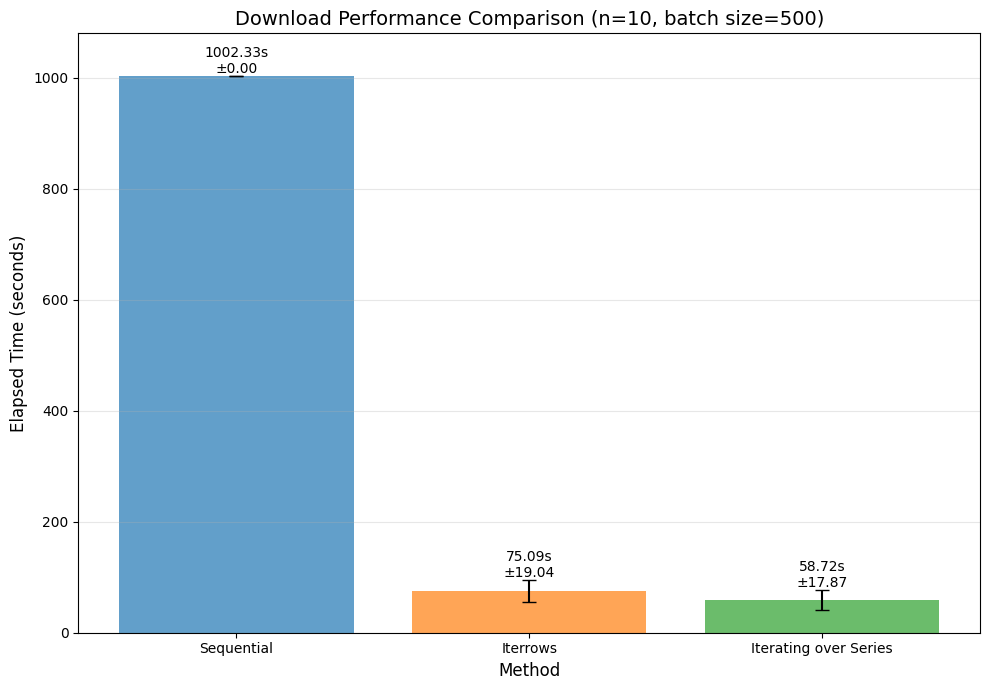

In [6]:
methods = ['Sequential', 'Iterrows', 'Iterating over Series']
x = np.arange(len(methods))
fig, ax = plt.subplots(figsize=(10, 7))

bars = ax.bar(x, means, yerr=std_devs, capsize=5, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Elapsed Time (seconds)', fontsize=12)
ax.set_ylim(0, 1080)
ax.set_title('Download Performance Comparison (n=10, batch size=500)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, std_devs)):
    ax.text(i, mean + std, f'{mean:.2f}s\n±{std:.2f}', 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

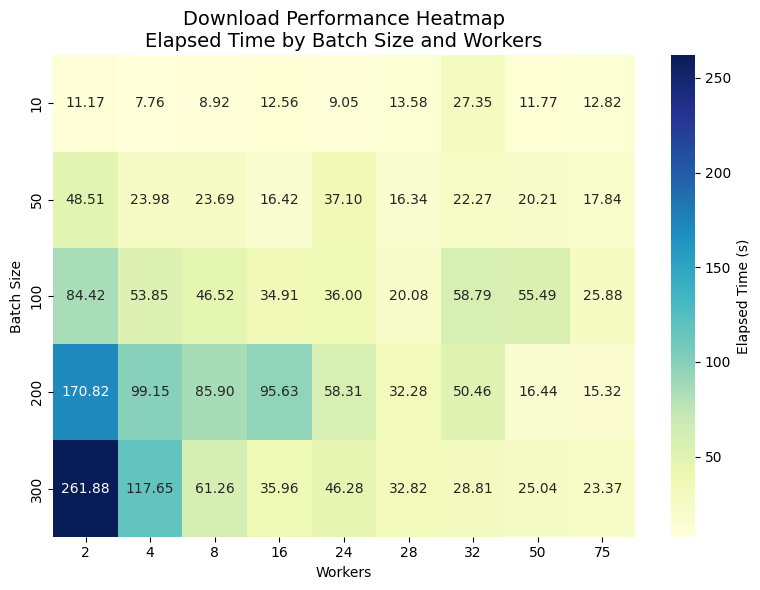

In [7]:
df_ = pd.read_json("benchmarks/benchmarks_vectorization_varying_params.json", orient="index")


pivot = df_.pivot_table(
    index="batch_size",
    columns="workers",
    values="elapsed_time",
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    annot=True, fmt=".2f", cmap="YlGnBu",
    cbar_kws={'label': 'Elapsed Time (s)'}
)

plt.title("Download Performance Heatmap\nElapsed Time by Batch Size and Workers", fontsize=14)
plt.xlabel("Workers")
plt.ylabel("Batch Size")

plt.tight_layout()
plt.show()

